In [5]:
# Bringing needed utilities

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense , Flatten , Reshape , LeakyReLU , Dropout , UpSampling2D
from matplotlib import pyplot as plt
import numpy as np
import random

In [6]:
# Downloading the fashion_mnist dataset
ds = tfds.load('fashion_mnist' , split = 'train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVWVAQS/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVWVAQS/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
# Scale and return the image only (without the label)
def scale_images(date):
  image = date['image']
  return image / 255

In [8]:
# Set up connection ake interator
data_iterator = ds.as_numpy_iterator()

In [9]:
# Running the dataset through the scale_images funtion
ds = ds.map(scale_images)

# Cache the dataset
ds = ds.cache()

# Shuffle the dataset
ds = ds.shuffle(60000)

# Batch into 128 images per sample 
ds = ds.batch(128)

# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
# Getting data out of the pipeline
data_iterator.next()

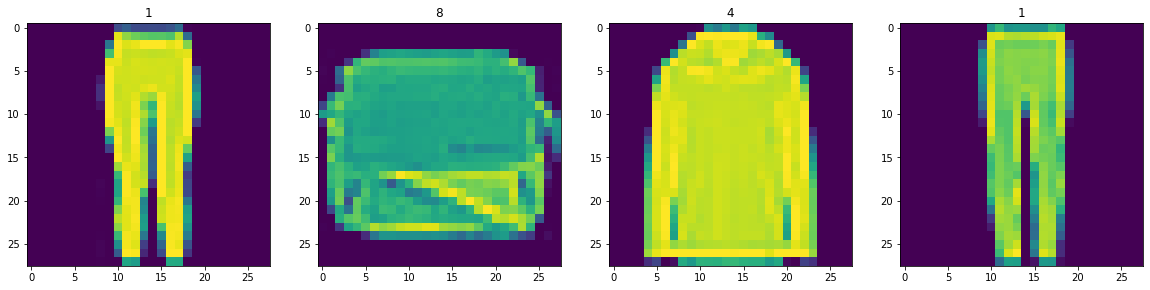

In [11]:
# Set up the subplot formatting
fig , ax = plt.subplots(ncols = 4 , figsize = (20 ,20))
# Loop and get four images
for idx in range(4):
  # Grab an image and label
  sample = data_iterator.next()
  # Plot the image in a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # Appending the image label as the plot title
  ax[idx].title.set_text(sample['label'])

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [13]:
# define the function to build the generator
def build_generator():
  model = Sequential()

  # Takes in random values and reshapes it into 7*7*128
  model.add(Dense(7*7*128 , input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128 ,  5 , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128 ,  5 , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Conv block 1
  model.add(Conv2D(128 , 4 , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Conv block 2
  model.add(Conv2D(128 , 4 , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get to one channel
  model.add(Conv2D(1,4,padding = 'same' , activation = 'sigmoid'))


  return model

In [27]:
from tensorflow_datasets.core.features.dataset_feature import sequence_feature
# Build the discriminator

def build_discriminator():
  model = Sequential()

  # First Conv block
  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second Conv block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))


  # Third Conv block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))


  # Fourth Conv block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))


  # Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1 , activation = 'sigmoid'))

  return model

In [28]:
generator = build_generator()
discriminator = build_discriminator()

In [15]:
# Bringing the Adam optimizer 
from tensorflow.keras.optimizers import Adam
# Bringing Binary Cross Entropy loss function
from tensorflow.keras.losses import BinaryCrossentropy

In [16]:
gen_opt , gen_loss = Adam(learning_rate= 0.0001) , BinaryCrossentropy()
dis_opt , dis_loss = Adam(learning_rate = 0.00001) , BinaryCrossentropy()

In [17]:
from tensorflow.keras.models import Model

In [18]:
class FashionGAN(Model):
  def __init__(self , generator , discriminator , *args , **kwargs):

    super().__init__(*args , **kwargs)
    self.generator = generator
    self.discriminator = discriminator

    
  def compile(self , gen_opt , dis_opt , gen_loss , dis_loss , *args , **kwargs):

      super().compile(*args , **kwargs)
      self.gen_opt = gen_opt
      self.gen_loss = gen_loss
      self.dis_opt = dis_opt
      self.dis_loss = dis_loss

  def train_step(self , batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128 , 128 ,1 )) , training = False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:

      # Pass the real and fake images to the disciminator model
      yhat_real = self.discriminator(real_images , training = True)
      yhat_fake = self.discriminator(fake_images , training = True)
      yhat_real_fake = tf.concat([yhat_real , yhat_fake] , axis = 0)

      # Creat labels for real and fake images
      y_real_fake = tf.concat([tf.zeros_like(yhat_real) , tf.ones_like(yhat_fake)] , axis = 0)

      # Add some noise to the outputs
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_real_fake += tf.concat([noise_real , noise_fake] , axis = 0)

      # Calculate loss (BinayCrossentropy)
      total_dis_loss = self.dis_loss(y_real_fake , yhat_real_fake)

    # Apply backpropagation (Learning)
    dgrad = d_tape.gradient(total_dis_loss , self.discriminator.trainable_variables)
    self.dis_opt.apply_gradients(zip(dgrad , self.discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.normal((128 ,128 ,1)) , training = True)

      # Create the predicted labels
      predicted_labels = self.discriminator(gen_images , training = False)

      # Calculate loss
      total_gen_loss = self.gen_loss(tf.zeros_like(predicted_labels) , predicted_labels)

    # Apply backpropegation
    ggrad = g_tape.gradient(total_gen_loss , self.generator.trainable_variables)
    self.gen_opt.apply_gradients(zip(ggrad , self.generator.trainable_variables))

    return {"dis_loss ":total_dis_loss , "gen_loss ":total_gen_loss}




In [29]:
fashgan = FashionGAN(generator , discriminator)

In [30]:
fashgan.compile(gen_opt , dis_opt , gen_loss , dis_loss)

In [20]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [22]:
class ModelMonitor(Callback):
  def __init__(self,num_img = 3 , latent_dim = 128):
    self.num_img = num_img
    self.latent_dim = latent_dim

    def on_epoch_end(self, epoch , logs = None):
      random_latent_vectors = tf.random.uniform((self.num_img , self.latent_dim ,1))
      generated_images = self.model.generator(random_latent_vectors)
      generated_images *= 255
      generated_images.numpy()

      for i in range(self.num_img):
        img = array_to_img(generated_images[i])
        img.save(os.path.join('images' , f'generatred_img_{epoch}_{i}.png'))

In [ ]:
hist = fashgan.fit(ds,epochs = 10 , callbacks = [ModelMonitor()])